# Bayesian Structural Time Series — Placebo Test on SIG Data

**Objective:** Implement the BSTS / CausalImpact model (Brodersen et al., 2015) and run a **placebo test** — apply the model to a period where **no price experimentation occurred** to verify that the model correctly identifies the absence of a causal effect.

**Data:**
- `OrderlineData 2-2-2026.repaired.csv` — 873k order lines from Aug 2023 onwards
- `SIG_BusinessCase_Q126.xlsx` — 5,440 products that underwent price experimentation in Q1 2026

**Design:**
- Aggregate order lines to **weekly** product-group-level time series
- Define a **placebo intervention** in a pre-experimentation period (e.g., July–August 2025)
- Use sales of **non-experimented products** as control series (synthetic control)
- Fit BSTS on the pre-placebo period, forecast the placebo window, and check that the model finds **no significant effect**

---

## 0. Setup & Installation

We use the `causalimpact` Python package (a port of Google's R CausalImpact). If not installed:

In [1]:
# Uncomment and run if needed:
# !pip install pycausalimpact
# !pip install causalimpact   # alternative: tfcausalimpact

# We'll also need:
# !pip install pymc arviz statsmodels

In [2]:
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from causalimpact import CausalImpact

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 160)
warnings.filterwarnings("ignore", category=FutureWarning)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Setup complete.")

Setup complete.


## 1. Configuration

Edit the paths and parameters below to match your local setup.

In [3]:
# ============================================================
# PATHS
# ============================================================
BASE_DIR = Path(r"C:\Users\vivan\Downloads\SYMSON\SIG")
OUT_DIR  = BASE_DIR / "Bayesian Structural Time Series Model"
OUT_DIR.mkdir(parents=True, exist_ok=True)

ORDERLINE_FILE   = BASE_DIR / "OrderlineData 2-2-2026.repaired.csv"
BUSINESS_CASE    = BASE_DIR / "SIG_BusinessCase_Q126.xlsx"

# ============================================================
# PLACEBO TEST DESIGN
# ============================================================
# We pick a one-month window where NO experimentation was done.
# The model should find no significant causal effect here.
#
# Pre-period:  everything before the placebo start
# Post-period: the one-month placebo window

PLACEBO_START = "2025-07-01"   # start of the fake "intervention"
PLACEBO_END   = "2025-07-31"   # end of the fake "intervention"
DATA_START    = "2023-08-01"   # earliest data to include
DATA_END      = "2025-09-30"   # latest safe date (well before Q1 2026 experimentation)

# Time series aggregation frequency
FREQ = "W-MON"  # weekly, starting Monday

# ============================================================
# RESPONSE VARIABLE
# ============================================================
# Which metric to model as the "outcome" of the intervention.
# Options: "TotalSalesAmount", "Quantity", "Revenue" (= TotalSalesAmount)
RESPONSE_METRIC = "TotalSalesAmount"

print(f"Placebo window:  {PLACEBO_START} to {PLACEBO_END}")
print(f"Output dir:      {OUT_DIR}")

Placebo window:  2025-07-01 to 2025-07-31
Output dir:      C:\Users\vivan\Downloads\SYMSON\SIG\Bayesian Structural Time Series Model


## 2. Load Data

In [4]:
# ---- Order lines ----
print("Loading order line data...")
df = pd.read_csv(ORDERLINE_FILE, low_memory=False)

# Parse dates
df["InvoiceCreatedDate"] = pd.to_datetime(df["InvoiceCreatedDate"], errors="coerce")
df["OrderLineCreatedDate"] = pd.to_datetime(df["OrderLineCreatedDate"], errors="coerce")

# Use the best available date column
df["Date"] = df["OrderLineCreatedDate"].fillna(df["InvoiceCreatedDate"])

# Ensure numeric columns
for col in ["TotalSalesAmount", "Quantity", "PricePerUnit", "MarginPerUnit",
            "TotalPurchaseCosts", "TotalCostPerUnit", "PurchaseCostPerUnit"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ProductId as string
df["ProductId"] = df["ProductId"].astype(str).str.strip()

# Filter to the safe date range
df = df[(df["Date"] >= DATA_START) & (df["Date"] <= DATA_END)].copy()

print(f"Order lines loaded: {len(df):,} rows, date range: {df['Date'].min()} to {df['Date'].max()}")

# ---- Business case (treated products) ----
bc = pd.read_excel(BUSINESS_CASE)
bc["ProductId"] = bc["ProductId"].astype(str).str.strip()
treated_products = set(bc["ProductId"].unique())

print(f"Business case products (treated): {len(treated_products):,}")
print(f"Overlap with order lines: {df['ProductId'].isin(treated_products).sum():,} rows")

Loading order line data...
Order lines loaded: 723,295 rows, date range: 2023-08-01 00:00:00 to 2025-09-30 00:00:00
Business case products (treated): 5,440
Overlap with order lines: 636,307 rows


## 3. Data Quality Checks

In [5]:
# ---- Basic checks ----
print("=" * 60)
print("DATA QUALITY OVERVIEW")
print("=" * 60)

# Date coverage
weekly_counts = df.set_index("Date").resample(FREQ).size()
print(f"\nWeekly order line counts:")
print(f"  Min: {weekly_counts.min():,.0f}  |  Median: {weekly_counts.median():,.0f}  |  Max: {weekly_counts.max():,.0f}")
print(f"  Weeks with zero orders: {(weekly_counts == 0).sum()}")

# Negative quantities / amounts
n_neg_qty = (df["Quantity"] < 0).sum()
n_neg_rev = (df["TotalSalesAmount"] < 0).sum()
print(f"\nNegative quantities: {n_neg_qty:,} ({100*n_neg_qty/len(df):.1f}%)")
print(f"Negative revenue:    {n_neg_rev:,} ({100*n_neg_rev/len(df):.1f}%)")

# Treated vs control product coverage
df["is_treated"] = df["ProductId"].isin(treated_products)
n_treated_products = df.loc[df["is_treated"], "ProductId"].nunique()
n_control_products = df.loc[~df["is_treated"], "ProductId"].nunique()
print(f"\nUnique treated products in orderlines:  {n_treated_products:,}")
print(f"Unique control products in orderlines:  {n_control_products:,}")

# Revenue split
rev_treated = df.loc[df["is_treated"], "TotalSalesAmount"].sum()
rev_control = df.loc[~df["is_treated"], "TotalSalesAmount"].sum()
print(f"\nTotal revenue (treated):  {rev_treated:,.0f}")
print(f"Total revenue (control):  {rev_control:,.0f}")
print(f"Treated share:            {100*rev_treated/(rev_treated+rev_control):.1f}%")

DATA QUALITY OVERVIEW

Weekly order line counts:
  Min: 17  |  Median: 7,194  |  Max: 11,158
  Weeks with zero orders: 0

Negative quantities: 23,617 (3.3%)
Negative revenue:    23,452 (3.2%)

Unique treated products in orderlines:  5,438
Unique control products in orderlines:  13,292

Total revenue (treated):  176,184,155
Total revenue (control):  24,205,514
Treated share:            87.9%


In [6]:
# ---- Filter out returns / credit notes ----
# Keep only positive quantities and positive revenue for cleaner time series
# (Returns introduce negative spikes that distort the BSTS model)

FILTER_NEGATIVES = True  # Set to False if you want to keep returns

if FILTER_NEGATIVES:
    before = len(df)
    df = df[(df["Quantity"] > 0) & (df["TotalSalesAmount"] > 0)].copy()
    print(f"Filtered negative qty/revenue: {before:,} -> {len(df):,} rows ({before - len(df):,} removed)")
else:
    print("Keeping all rows (including returns).")

Filtered negative qty/revenue: 723,295 -> 695,001 rows (28,294 removed)


## 4. Build Weekly Time Series

The BSTS model requires:
1. **Response series (`y`)**: weekly aggregated metric for the *treated* products
2. **Control series (`X`)**: one or more time series that are *not affected* by the intervention and help explain variance in the response

### What makes a good control series?

Per Brodersen et al. (2015), control series should:
- **Not be affected by the treatment** (products that did NOT receive price changes)
- **Be predictive of the response** in the pre-intervention period (share seasonal patterns, market trends)
- **Be contemporaneous** (measured at the same time frequency)

We construct several candidate controls from the available data:

| Control Series | Description | Rationale |
|---|---|---|
| `control_revenue` | Total revenue of all non-treated products | Captures market-wide demand shifts, seasonality |
| `control_quantity` | Total quantity of all non-treated products | Same, but unit-based (robust to price changes) |
| `n_invoices` | Total number of unique invoices per week | Proxy for overall business activity / foot traffic |
| `n_customers` | Number of unique customers per week | Customer-level demand indicator |
| `avg_margin_control` | Average margin per unit (control products) | Captures cost/pricing environment changes |

### What additional data could improve the model?

The model would benefit from **external covariates** not available in the order lines:

| Covariate | Why it helps | Where to get it |
|---|---|---|
| **Construction sector index** | SIG sells building materials; sector activity drives demand | CBS (Dutch statistics), Eurostat |
| **Weather data** | Construction/building activity is weather-dependent | KNMI (Dutch weather service) |
| **Raw material prices** | Affects purchasing behaviour and margin | Industry indices, commodity data |
| **Competitor pricing** | Competitor actions confound price sensitivity | If available from SIG |
| **Holiday/calendar dummies** | Business days per week vary; holidays suppress orders | Public calendar |
| **Google Trends** | Search interest for SIG's product categories | Google Trends API |

For now, we proceed with the internal controls. These are sufficient for the placebo test.

In [7]:
# ============================================================
# 4A) Build the response series (treated products)
# ============================================================

treated_df = df[df["is_treated"]].copy()
control_df = df[~df["is_treated"]].copy()

# Weekly aggregation
y_treated = (
    treated_df
    .set_index("Date")
    .resample(FREQ)
    .agg({
        "TotalSalesAmount": "sum",
        "Quantity": "sum",
        "InvoiceId": "nunique",
    })
    .rename(columns={
        "TotalSalesAmount": "y_revenue",
        "Quantity": "y_quantity",
        "InvoiceId": "y_invoices",
    })
)

print(f"Treated weekly series: {len(y_treated)} weeks")
print(f"Date range: {y_treated.index.min()} to {y_treated.index.max()}")
y_treated.head()

Treated weekly series: 114 weeks
Date range: 2023-08-07 00:00:00 to 2025-10-06 00:00:00


,y_revenue,y_quantity,y_invoices
Date,,,
2023-08-07,546481.27,142406.3741,807
2023-08-14,729315.01,160708.3334,1311
2023-08-21,875641.97,165925.4608,1349
2023-08-28,1470553.38,362443.6317,2038
2023-09-04,1867518.92,422661.6895,2192


In [8]:
# ============================================================
# 4B) Build control series (non-treated products)
# ============================================================

x_control = (
    control_df
    .set_index("Date")
    .resample(FREQ)
    .agg({
        "TotalSalesAmount": "sum",
        "Quantity": "sum",
        "InvoiceId": "nunique",
        "CustomerId": "nunique",
        "MarginPerUnit": "mean",
    })
    .rename(columns={
        "TotalSalesAmount": "ctrl_revenue",
        "Quantity": "ctrl_quantity",
        "InvoiceId": "ctrl_invoices",
        "CustomerId": "ctrl_customers",
        "MarginPerUnit": "ctrl_avg_margin",
    })
)

# Also build an overall business activity control (all products)
x_overall = (
    df
    .set_index("Date")
    .resample(FREQ)
    .agg({
        "InvoiceId": "nunique",
        "CustomerId": "nunique",
    })
    .rename(columns={
        "InvoiceId": "total_invoices",
        "CustomerId": "total_customers",
    })
)

print(f"Control weekly series: {len(x_control)} weeks")
x_control.head()

Control weekly series: 114 weeks


,ctrl_revenue,ctrl_quantity,ctrl_invoices,ctrl_customers,ctrl_avg_margin
Date,,,,,
2023-08-07,70047.61,9098.2020,232,150,6.546444
2023-08-14,232851.97,29449.6340,449,276,10.940741
2023-08-21,172890.45,22085.3067,489,320,9.627902
2023-08-28,246499.35,30344.0122,680,397,-833.557032
2023-09-04,449710.47,50030.8943,754,453,-619.431950


In [9]:
# ============================================================
# 4C) Combine into a single DataFrame for CausalImpact
# ============================================================

# CausalImpact expects a DataFrame where:
#   - Column 0 = response (y)
#   - Columns 1+ = covariates (controls)
#   - Index = DatetimeIndex

# Choose the response metric
if RESPONSE_METRIC == "TotalSalesAmount":
    response_col = "y_revenue"
elif RESPONSE_METRIC == "Quantity":
    response_col = "y_quantity"
else:
    response_col = "y_revenue"

ts = pd.concat([y_treated[[response_col]], x_control, x_overall], axis=1)
ts = ts.sort_index()

# Fill any missing weeks (should be rare) with forward fill, then backfill
ts = ts.ffill().bfill()

# Drop any weeks where the response is zero or NaN (incomplete weeks at boundaries)
ts = ts[ts[response_col] > 0].copy()

print(f"Combined time series: {len(ts)} weeks x {ts.shape[1]} columns")
print(f"Date range: {ts.index.min()} to {ts.index.max()}")
print(f"\nColumns: {list(ts.columns)}")
ts.describe().round(1)

Combined time series: 114 weeks x 8 columns
Date range: 2023-08-07 00:00:00 to 2025-10-06 00:00:00

Columns: ['y_revenue', 'ctrl_revenue', 'ctrl_quantity', 'ctrl_invoices', 'ctrl_customers', 'ctrl_avg_margin', 'total_invoices', 'total_customers']


,y_revenue,ctrl_revenue,ctrl_quantity,ctrl_invoices,ctrl_customers,ctrl_avg_margin,total_invoices,total_customers
count,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0
mean,1627327.3,232351.1,29089.7,383.5,237.3,0.9,1664.3,647.9
std,503304.2,146328.6,18750.0,279.9,172.0,111.7,801.1,307.7
min,25512.0,1408.4,190.0,1.0,1.0,-833.6,8.0,8.0
25%,1493303.6,117284.8,13943.9,79.5,46.0,6.6,947.0,348.2
50%,1758230.2,233170.7,29520.7,478.5,318.0,8.0,1859.5,786.5
75%,1925678.3,315848.8,40282.1,637.2,394.5,9.7,2424.8,937.8
max,3449816.2,1069595.4,138973.8,789.0,475.0,556.3,2788.0,1034.0


## 5. Exploratory Visualisation

Before running the model, inspect the time series visually.

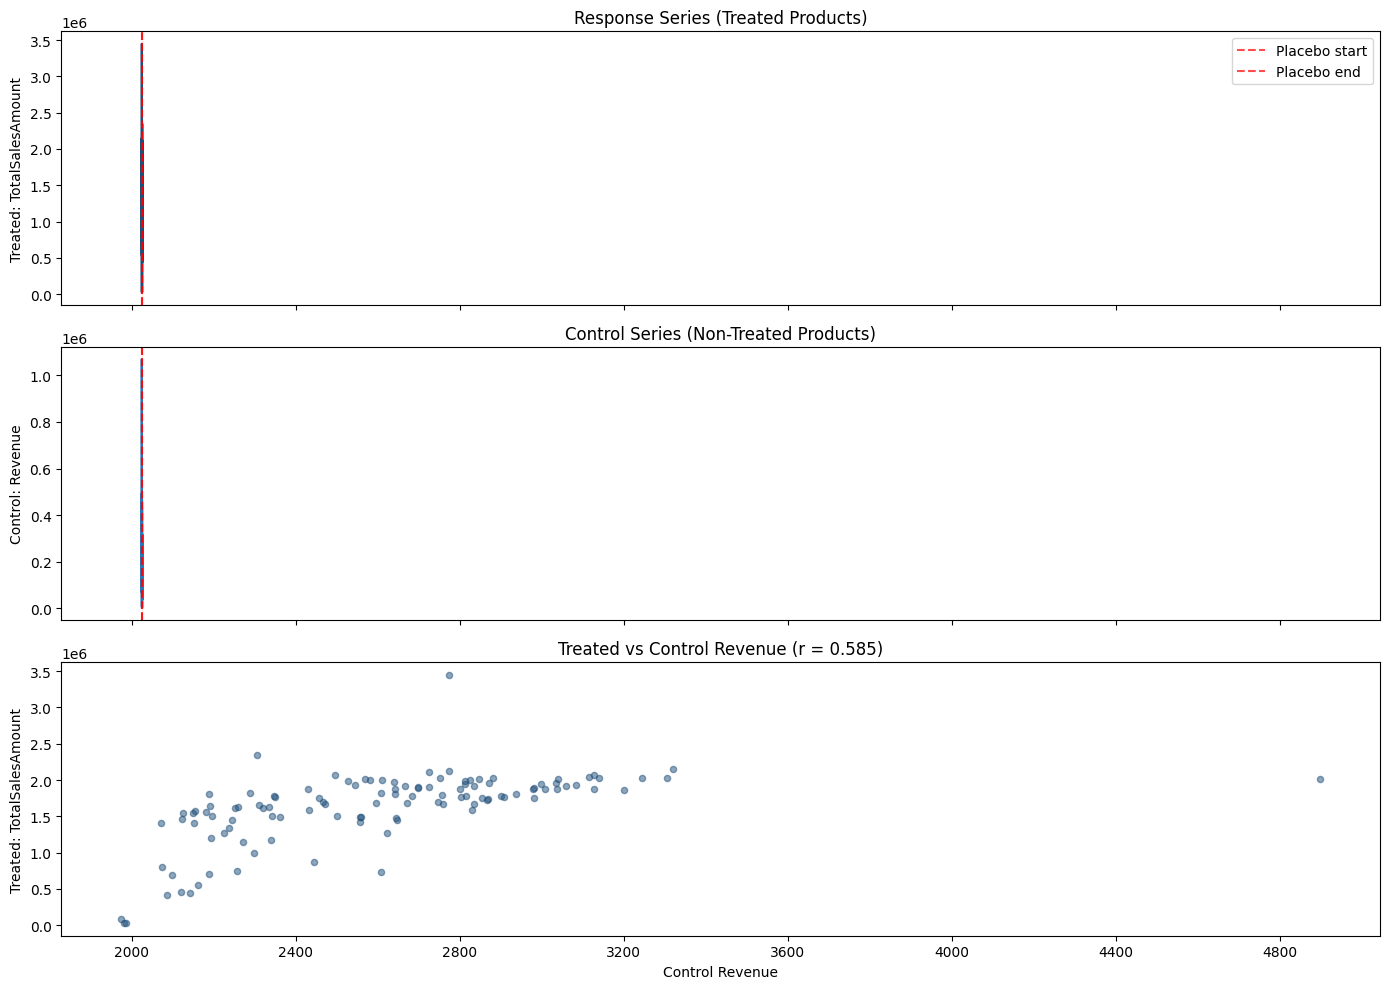

Correlation between treated and control revenue: 0.585


In [10]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Response
axes[0].plot(ts.index, ts[response_col], color="#1F4E79", linewidth=1.5)
axes[0].axvline(pd.Timestamp(PLACEBO_START), color="red", linestyle="--", alpha=0.7, label="Placebo start")
axes[0].axvline(pd.Timestamp(PLACEBO_END), color="red", linestyle="--", alpha=0.7, label="Placebo end")
axes[0].axvspan(pd.Timestamp(PLACEBO_START), pd.Timestamp(PLACEBO_END), alpha=0.1, color="red")
axes[0].set_ylabel(f"Treated: {RESPONSE_METRIC}")
axes[0].set_title("Response Series (Treated Products)")
axes[0].legend()

# Control revenue
axes[1].plot(ts.index, ts["ctrl_revenue"], color="#2E75B6", linewidth=1.5)
axes[1].axvline(pd.Timestamp(PLACEBO_START), color="red", linestyle="--", alpha=0.7)
axes[1].axvline(pd.Timestamp(PLACEBO_END), color="red", linestyle="--", alpha=0.7)
axes[1].axvspan(pd.Timestamp(PLACEBO_START), pd.Timestamp(PLACEBO_END), alpha=0.1, color="red")
axes[1].set_ylabel("Control: Revenue")
axes[1].set_title("Control Series (Non-Treated Products)")

# Correlation check
axes[2].scatter(ts["ctrl_revenue"], ts[response_col], alpha=0.5, s=20, color="#1F4E79")
axes[2].set_xlabel("Control Revenue")
axes[2].set_ylabel(f"Treated: {RESPONSE_METRIC}")
corr = ts["ctrl_revenue"].corr(ts[response_col])
axes[2].set_title(f"Treated vs Control Revenue (r = {corr:.3f})")

plt.tight_layout()
plt.savefig(OUT_DIR / "01_time_series_overview.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Correlation between treated and control revenue: {corr:.3f}")

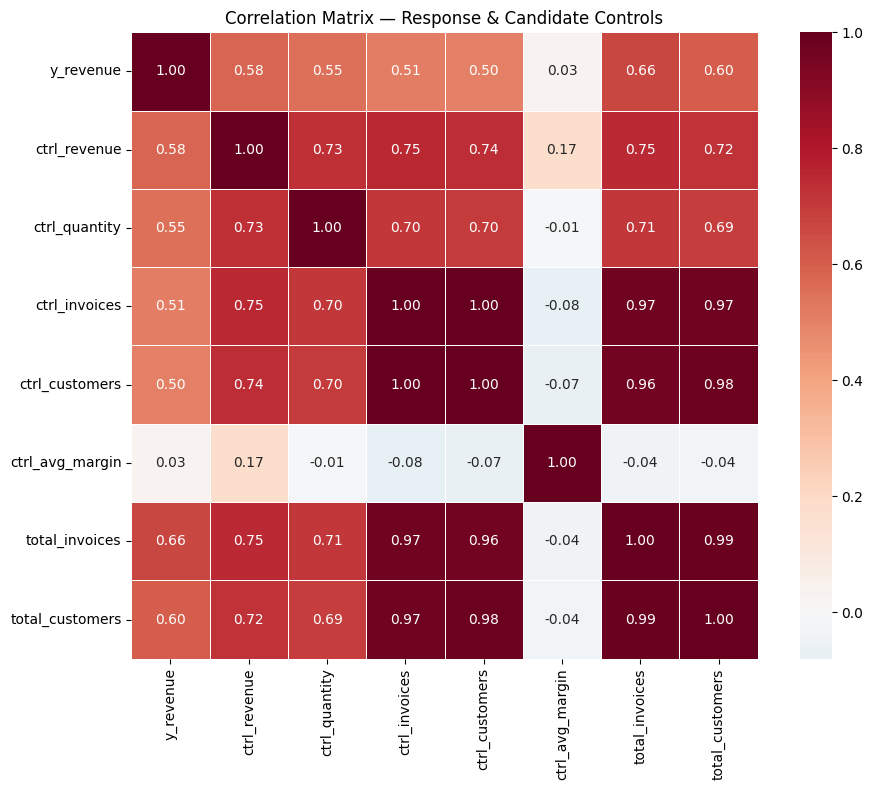


Correlation with response:
y_revenue          1.000000
total_invoices     0.663554
total_customers    0.604980
ctrl_revenue       0.584527
ctrl_quantity      0.550592
ctrl_invoices      0.511984
ctrl_customers     0.501217
ctrl_avg_margin    0.031652


In [11]:
# ---- Correlation matrix of all candidate controls ----
corr_matrix = ts.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
            square=True, linewidths=0.5, ax=ax)
ax.set_title("Correlation Matrix — Response & Candidate Controls")
plt.tight_layout()
plt.savefig(OUT_DIR / "02_correlation_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nCorrelation with response:")
print(corr_matrix[response_col].sort_values(ascending=False).to_string())

## 6. Select Controls & Prepare for CausalImpact

Based on the correlation matrix, select the most predictive controls. 
Drop controls that are:
- Highly correlated with each other (multicollinearity)
- Weakly correlated with the response

The BSTS model internally uses a **spike-and-slab prior** for variable selection, so it can handle moderate multicollinearity. But it's still good practice to be deliberate.

In [12]:
# ============================================================
# Select controls for the model
# ============================================================

# Start with all available controls. Drop any with |corr| < 0.3 with the response.
MIN_CORR = 0.3

candidate_controls = [c for c in ts.columns if c != response_col]

selected_controls = []
for c in candidate_controls:
    r = abs(ts[c].corr(ts[response_col]))
    if r >= MIN_CORR:
        selected_controls.append(c)
        print(f"  KEEP  {c:25s}  |corr| = {r:.3f}")
    else:
        print(f"  DROP  {c:25s}  |corr| = {r:.3f}  (below {MIN_CORR})")

print(f"\nSelected {len(selected_controls)} controls: {selected_controls}")

# ---- Build the final DataFrame for CausalImpact ----
# Column order: response first, then controls
model_data = ts[[response_col] + selected_controls].copy()

# Rename response to 'y' for clarity
model_data = model_data.rename(columns={response_col: "y"})

print(f"\nFinal model data: {model_data.shape[0]} weeks x {model_data.shape[1]} columns")
model_data.head()

  KEEP  ctrl_revenue               |corr| = 0.585
  KEEP  ctrl_quantity              |corr| = 0.551
  KEEP  ctrl_invoices              |corr| = 0.512
  KEEP  ctrl_customers             |corr| = 0.501
  DROP  ctrl_avg_margin            |corr| = 0.032  (below 0.3)
  KEEP  total_invoices             |corr| = 0.664
  KEEP  total_customers            |corr| = 0.605

Selected 6 controls: ['ctrl_revenue', 'ctrl_quantity', 'ctrl_invoices', 'ctrl_customers', 'total_invoices', 'total_customers']

Final model data: 114 weeks x 7 columns


,y,ctrl_revenue,ctrl_quantity,ctrl_invoices,ctrl_customers,total_invoices,total_customers
Date,,,,,,,
2023-08-07,546481.27,70047.61,9098.2020,232,150,850,402
2023-08-14,729315.01,232851.97,29449.6340,449,276,1421,613
2023-08-21,875641.97,172890.45,22085.3067,489,320,1452,667
2023-08-28,1470553.38,246499.35,30344.0122,680,397,2182,813
2023-09-04,1867518.92,449710.47,50030.8943,754,453,2364,904


## 7. Run the Placebo Test

### Model specification

The BSTS model from Brodersen et al. (2015) consists of:

$$y_t = Z_t^\top \alpha_t + \varepsilon_t \quad (\text{observation equation})$$
$$\alpha_{t+1} = T_t \alpha_t + R_t \eta_t \quad (\text{state equation})$$

The state $\alpha_t$ is assembled from:
1. **Local linear trend**: $\mu_{t+1} = \mu_t + \delta_t + \eta_{\mu,t}$, $\;\delta_{t+1} = \delta_t + \eta_{\delta,t}$
2. **Seasonality** (optional): $\gamma_{t+1} = -\sum_{s=0}^{S-2} \gamma_{t-s} + \eta_{\gamma,t}$
3. **Regression on controls**: $x_t^\top \beta$ with spike-and-slab prior for variable selection

The causal effect is estimated as:
$$\phi_t = y_t - \tilde{y}_t \quad \forall t \in \text{post-intervention}$$

where $\tilde{y}_t$ is the posterior predictive counterfactual.

### Placebo design

Since no price experimentation occurred during the placebo window, we expect:
- The cumulative effect should be **not significantly different from zero**
- The 95% credible interval of the cumulative effect should **contain zero**

In [13]:
# ============================================================
# Define pre- and post-intervention periods
# ============================================================

pre_period  = [model_data.index.min(), pd.Timestamp(PLACEBO_START) - pd.Timedelta(days=1)]
post_period = [pd.Timestamp(PLACEBO_START), pd.Timestamp(PLACEBO_END)]

# Ensure the periods align with the actual index
# (find the closest available dates)
pre_start  = model_data.index[model_data.index >= pre_period[0]][0]
pre_end    = model_data.index[model_data.index <= pre_period[1]][-1]
post_start = model_data.index[model_data.index >= post_period[0]][0]
post_end   = model_data.index[model_data.index <= post_period[1]][-1]

pre_period  = [pre_start, pre_end]
post_period = [post_start, post_end]

n_pre  = len(model_data.loc[pre_start:pre_end])
n_post = len(model_data.loc[post_start:post_end])

print(f"Pre-intervention period:  {pre_period[0].date()} to {pre_period[1].date()}  ({n_pre} weeks)")
print(f"Post-intervention period: {post_period[0].date()} to {post_period[1].date()}  ({n_post} weeks)")

Pre-intervention period:  2023-08-07 to 2025-06-30  (100 weeks)
Post-intervention period: 2025-07-07 to 2025-07-28  (4 weeks)


In [14]:
# ============================================================
# Fit the CausalImpact model
# ============================================================

print("Fitting CausalImpact model...")
print(f"  Response: y ({RESPONSE_METRIC} of treated products)")
print(f"  Controls: {selected_controls}")
print(f"  Pre:  {pre_period[0].date()} to {pre_period[1].date()}")
print(f"  Post: {post_period[0].date()} to {post_period[1].date()}")
print()

ci = CausalImpact(
    model_data,
    pre_period,
    post_period,
    # Model options (uncomment/adjust as needed):
    # nseasons=[{"period": 52}],  # annual seasonality for weekly data
    # prior_level_sd=0.01,         # prior on local level standard deviation
)

print("Model fit complete.")

Fitting CausalImpact model...
  Response: y (TotalSalesAmount of treated products)
  Controls: ['ctrl_revenue', 'ctrl_quantity', 'ctrl_invoices', 'ctrl_customers', 'total_invoices', 'total_customers']
  Pre:  2023-08-07 to 2025-06-30
  Post: 2025-07-07 to 2025-07-28

Model fit complete.


In [15]:
# ============================================================
# Results: Summary & Plots
# ============================================================

print(ci.summary())
print("\n" + "=" * 80)
print(ci.summary(output="report"))

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1465162.62         5860650.5
Prediction (s.d.)         1511393.68 (132613.74)6045574.7 (530454.98)
95% CI                    [1247833.89, 1767670.21][4991335.56, 7070680.86]

Absolute effect (s.d.)    -46231.05 (132613.74)-184924.2 (530454.98)
95% CI                    [-302507.59, 217328.74][-1210030.36, 869314.94]

Relative effect (s.d.)    -3.06% (8.77%)     -3.06% (8.77%)
95% CI                    [-20.02%, 14.38%]  [-20.02%, 14.38%]

Posterior tail-area probability p: 0.35
Posterior prob. of a causal effect: 64.94%

For more details run the command: print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1465162.62. In the absence of an
intervention, we would have expected an average response of 1511393.68.
The 95% interval of this counterfactual prediction is [1247

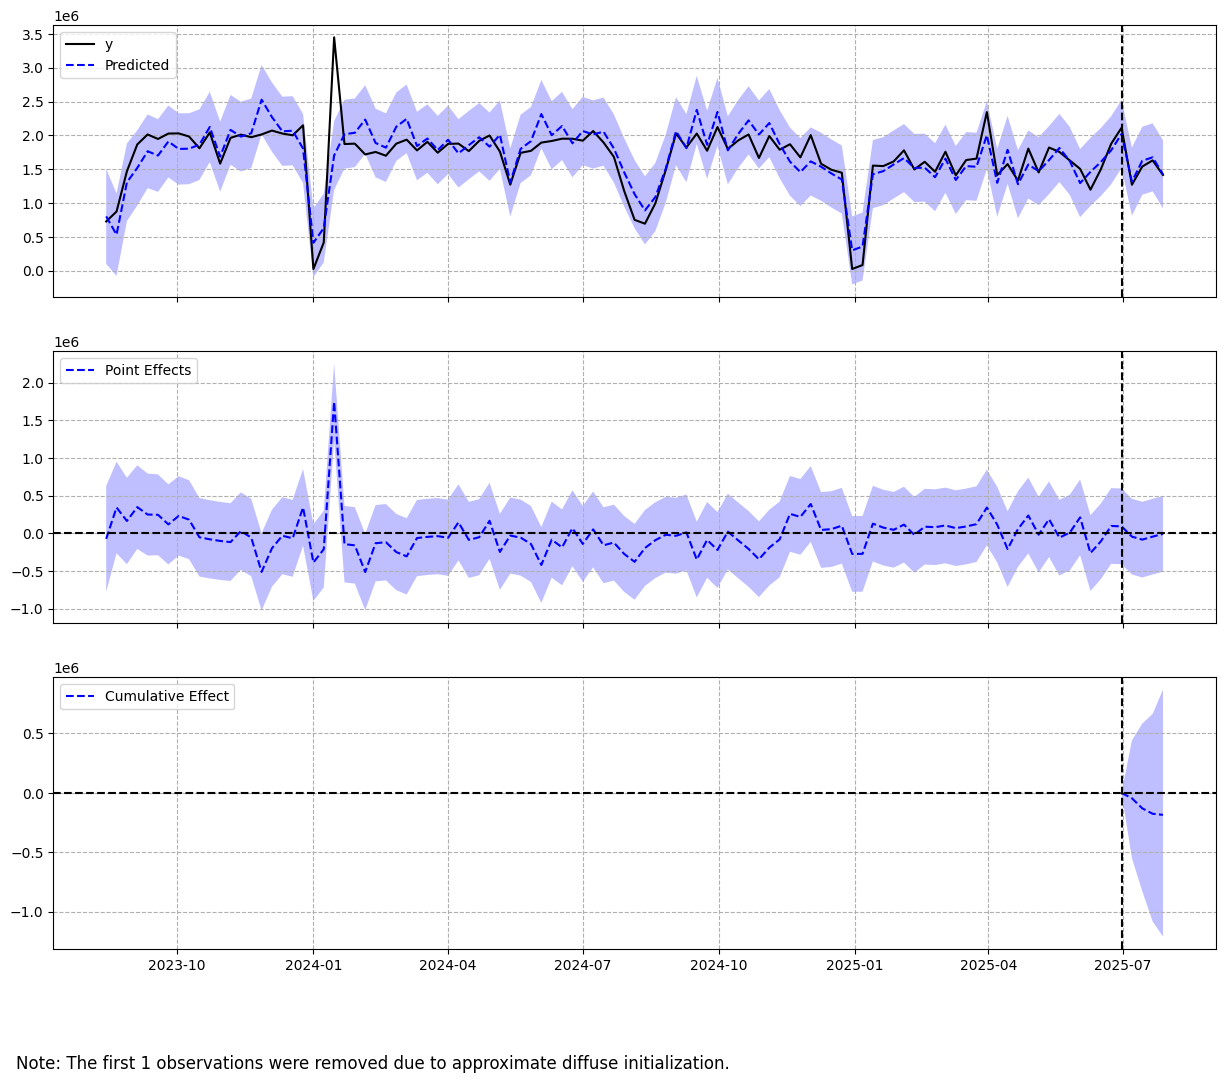

<Figure size 1400x1000 with 0 Axes>

In [16]:
# ---- Standard CausalImpact plot ----
ci.plot()
plt.gcf().set_size_inches(14, 10)
plt.savefig(OUT_DIR / "03_placebo_causal_impact.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Interpret the Placebo Test

### What to look for:

| Outcome | Interpretation |
|---|---|
| 95% CI of cumulative effect **contains zero** | **PASS** — model correctly identifies no effect |
| p-value > 0.05 | **PASS** — no statistically significant effect detected |
| 95% CI of cumulative effect **excludes zero** | **FAIL** — model detects a spurious effect (possible confounding, poor controls, or structural break) |

A passing placebo test gives confidence that the model's controls and trend components adequately capture the baseline demand process, and that any effect detected during *actual* experimentation is more likely causal.

In [17]:
# ============================================================
# Helper: extract summary metrics (compatible across package versions)
# ============================================================
# The `from causalimpact import CausalImpact` package stores summary_data
# with metric names as ROWS (index) and 'average'/'cumulative' as COLUMNS.
#
#   summary_data layout:
#     Rows:    actual, predicted, predicted_lower, ..., rel_effect_upper
#     Columns: average, cumulative

def extract_ci_metrics(ci_obj):
    """Extract key metrics from a CausalImpact object.

    Reads metrics from the INDEX (rows) and aggregation level
    from COLUMNS ('average' / 'cumulative').
    """
    sd = ci_obj.summary_data

    def _safe(row, col="average"):
        try:
            return sd.loc[row, col]
        except KeyError:
            return np.nan

    metrics = {
        "avg_effect":       _safe("abs_effect",       "average"),
        "avg_effect_lower": _safe("abs_effect_lower", "average"),
        "avg_effect_upper": _safe("abs_effect_upper", "average"),
        "cum_effect":       _safe("abs_effect",       "cumulative"),
        "cum_lower":        _safe("abs_effect_lower", "cumulative"),
        "cum_upper":        _safe("abs_effect_upper", "cumulative"),
        "rel_effect":       _safe("rel_effect",       "average"),
        "rel_effect_lower": _safe("rel_effect_lower", "average"),
        "rel_effect_upper": _safe("rel_effect_upper", "average"),
    }

    # p-value: check attribute first, then summary_data rows
    if hasattr(ci_obj, "p_value") and ci_obj.p_value is not None:
        metrics["p_value"] = ci_obj.p_value
    elif "p" in sd.index:
        metrics["p_value"] = _safe("p", "average")
    elif "p_value" in sd.index:
        metrics["p_value"] = _safe("p_value", "average")
    else:
        metrics["p_value"] = np.nan

    return metrics


def ci_verdict(m):
    """Return verdict string from metrics dict.

    PASS  = cumulative CI includes zero AND (p > 0.05 or p unavailable)
    FAIL  = spurious effect detected
    """
    cum_lower = m.get("cum_lower", np.nan)
    cum_upper = m.get("cum_upper", np.nan)
    p = m.get("p_value", np.nan)

    ci_zero = (
        (not np.isnan(cum_lower))
        and (not np.isnan(cum_upper))
        and (cum_lower <= 0 <= cum_upper)
    )
    p_ok = (not np.isnan(p)) and (p > 0.05)

    if ci_zero and p_ok:
        return "PASS"
    elif ci_zero and np.isnan(p):
        return "PASS (CI only)"
    elif ci_zero:
        return "MARGINAL PASS"
    elif not np.isnan(p) and p > 0.05:
        return "MARGINAL PASS (p only)"
    else:
        return "FAIL"


# ============================================================
# Formal placebo test evaluation
# ============================================================

# First, show the raw summary_data so you can see exactly what columns exist
print("Raw summary_data from CausalImpact:")
print(ci.summary_data)
print()

m = extract_ci_metrics(ci)

print("\n" + "=" * 60)
print("PLACEBO TEST RESULTS")
print("=" * 60)
print(f"\nAverage effect:    {m['avg_effect']:.2f}  [{m['avg_effect_lower']:.2f}, {m['avg_effect_upper']:.2f}]")
print(f"Cumulative effect: {m['cum_effect']:.2f}  [{m['cum_lower']:.2f}, {m['cum_upper']:.2f}]")
print(f"Relative effect:   {m['rel_effect']:.4f}  [{m['rel_effect_lower']:.4f}, {m['rel_effect_upper']:.4f}]")
print(f"p-value:           {m['p_value']}")

verdict = ci_verdict(m)
print("\n" + "-" * 60)
print(f"Verdict: {verdict}")

if "PASS" in verdict:
    print("The model correctly identifies NO significant causal effect.")
    print("This validates the model's controls and trend specification.")
elif verdict == "FAIL":
    print("The model detects a spurious effect during the placebo window.")
    print("Possible causes:")
    print("  - Controls don't adequately capture demand shifts in this period")
    print("  - Structural break (e.g., SIG changed pricing/catalogue in this period)")
    print("  - Seasonal component not captured by the controls")
    print("  - Consider adding external covariates (see Section 4 table)")
    print("  - Try a different placebo window")


Raw summary_data from CausalImpact:
                       average    cumulative
actual            1.465163e+06  5.860650e+06
predicted         1.511394e+06  6.045575e+06
predicted_lower   1.247834e+06  4.991336e+06
predicted_upper   1.767670e+06  7.070681e+06
abs_effect       -4.623105e+04 -1.849242e+05
abs_effect_lower -3.025076e+05 -1.210030e+06
abs_effect_upper  2.173287e+05  8.693149e+05
rel_effect       -3.058836e-02 -3.058836e-02
rel_effect_lower -2.001514e-01 -2.001514e-01
rel_effect_upper  1.437936e-01  1.437936e-01


PLACEBO TEST RESULTS

Average effect:    -46231.05  [-302507.59, 217328.74]
Cumulative effect: -184924.20  [-1210030.36, 869314.94]
Relative effect:   -0.0306  [-0.2002, 0.1438]
p-value:           0.35064935064935066

------------------------------------------------------------
Verdict: PASS
The model correctly identifies NO significant causal effect.
This validates the model's controls and trend specification.


## 9. Sensitivity Analysis

Run the placebo test under different configurations to check robustness.

In [18]:
# ============================================================
# 9A) Try different placebo windows
# ============================================================

PLACEBO_WINDOWS = [
    ("2024-04-01", "2024-04-30", "Apr 2024"),
    ("2024-07-01", "2024-07-31", "Jul 2024"),
    ("2024-10-01", "2024-10-31", "Oct 2024"),
    ("2025-01-01", "2025-01-31", "Jan 2025"),
    ("2025-04-01", "2025-04-30", "Apr 2025"),
    ("2025-07-01", "2025-07-31", "Jul 2025"),
]

results_sensitivity = []

for start, end, label in PLACEBO_WINDOWS:
    try:
        cutoff = pd.Timestamp(end) + pd.Timedelta(weeks=4)
        data_subset = model_data[model_data.index <= cutoff].copy()

        pre_s = data_subset.index[0]
        pre_e = data_subset.index[data_subset.index < pd.Timestamp(start)][-1]
        post_s = data_subset.index[data_subset.index >= pd.Timestamp(start)][0]
        post_e = data_subset.index[data_subset.index <= pd.Timestamp(end)][-1]

        ci_test = CausalImpact(data_subset, [pre_s, pre_e], [post_s, post_e])
        mt = extract_ci_metrics(ci_test)

        results_sensitivity.append({
            "Window": label,
            "Start": start,
            "End": end,
            "Relative Effect": mt["rel_effect"],
            "p-value": mt["p_value"],
            "Verdict": ci_verdict(mt),
        })
        print(f"  {label}: rel_effect = {mt['rel_effect']}, p = {mt['p_value']}")

    except Exception as e:
        print(f"  {label}: SKIPPED ({e})")
        results_sensitivity.append({"Window": label, "Verdict": f"ERROR: {e}"})

sensitivity_df = pd.DataFrame(results_sensitivity)
print("\n" + "=" * 60)
print("SENSITIVITY ANALYSIS — PLACEBO TESTS ACROSS WINDOWS")
print("=" * 60)
print(sensitivity_df.to_string(index=False))

sensitivity_df.to_csv(OUT_DIR / "placebo_sensitivity_analysis.csv", index=False)


  Apr 2024: rel_effect = -0.005625946903210333, p = 0.4875124875124875
  Jul 2024: rel_effect = -0.028310979244804545, p = 0.3596403596403596
  Oct 2024: rel_effect = -0.03598447849775665, p = 0.3066933066933067
  Jan 2025: rel_effect = 0.12492294293396336, p = 0.17282717282717283
  Apr 2025: rel_effect = 0.04008691313314995, p = 0.3086913086913087
  Jul 2025: rel_effect = -0.030588358138909647, p = 0.36863136863136864

SENSITIVITY ANALYSIS — PLACEBO TESTS ACROSS WINDOWS
  Window      Start        End  Relative Effect  p-value Verdict
Apr 2024 2024-04-01 2024-04-30        -0.005626 0.487512    PASS
Jul 2024 2024-07-01 2024-07-31        -0.028311 0.359640    PASS
Oct 2024 2024-10-01 2024-10-31        -0.035984 0.306693    PASS
Jan 2025 2025-01-01 2025-01-31         0.124923 0.172827    PASS
Apr 2025 2025-04-01 2025-04-30         0.040087 0.308691    PASS
Jul 2025 2025-07-01 2025-07-31        -0.030588 0.368631    PASS


In [19]:
# ============================================================
# 9B) Try different control combinations
# ============================================================

control_combos = []

control_sets = [
    ["ctrl_revenue"],
    ["ctrl_revenue", "ctrl_quantity"],
    ["ctrl_revenue", "ctrl_customers"],
    ["ctrl_revenue", "ctrl_invoices"],
    selected_controls,  # full set
]

for ctrl_set in control_sets:
    valid_cols = [c for c in ctrl_set if c in model_data.columns]
    if not valid_cols:
        continue

    subset = model_data[["y"] + valid_cols].copy()

    try:
        ci_ctrl = CausalImpact(subset, pre_period, post_period)
        mt = extract_ci_metrics(ci_ctrl)

        control_combos.append({
            "Controls": ", ".join(valid_cols),
            "N Controls": len(valid_cols),
            "Relative Effect": mt["rel_effect"],
            "p-value": mt["p_value"],
            "Verdict": ci_verdict(mt),
        })
    except Exception as e:
        control_combos.append({"Controls": ", ".join(valid_cols), "Verdict": f"ERROR: {e}"})

combos_df = pd.DataFrame(control_combos)
print("\n" + "=" * 60)
print("CONTROL SET COMPARISON")
print("=" * 60)
print(combos_df.to_string(index=False))



CONTROL SET COMPARISON
                                                                                   Controls  N Controls  Relative Effect  p-value Verdict
                                                                               ctrl_revenue           1        -0.011909 0.468531    PASS
                                                                ctrl_revenue, ctrl_quantity           2         0.013073 0.463536    PASS
                                                               ctrl_revenue, ctrl_customers           2         0.029016 0.420579    PASS
                                                                ctrl_revenue, ctrl_invoices           2         0.029702 0.415584    PASS
ctrl_revenue, ctrl_quantity, ctrl_invoices, ctrl_customers, total_invoices, total_customers           6        -0.030588 0.371628    PASS


## 10. Per-Product Analysis (Optional)

Instead of aggregating all treated products, run the model on **individual high-volume products** to check whether the placebo test holds at the product level.

In [20]:
# ============================================================
# Identify top products by revenue
# ============================================================

product_revenue = (
    treated_df
    .groupby("ProductId")["TotalSalesAmount"]
    .sum()
    .sort_values(ascending=False)
)

# Select top N products with enough weekly observations
TOP_N = 5
MIN_WEEKS = 40  # need enough pre-intervention data

top_products = []
for pid in product_revenue.index:
    weekly = treated_df[treated_df["ProductId"] == pid].set_index("Date").resample(FREQ)["TotalSalesAmount"].sum()
    n_nonzero = (weekly > 0).sum()
    if n_nonzero >= MIN_WEEKS:
        top_products.append(pid)
    if len(top_products) >= TOP_N:
        break

print(f"Selected {len(top_products)} products for per-product analysis:")
for pid in top_products:
    name = bc.loc[bc["ProductId"] == pid, "Name"].values
    name = name[0] if len(name) > 0 else "N/A"
    print(f"  {pid} — {name[:60]} — Revenue: {product_revenue[pid]:,.0f}")

Selected 5 products for per-product analysis:
  100290012 — Gyproc AK (A) 3000x1200x12,5 mm — Revenue: 5,257,273
  100160911 — Knauf Machinepleister MP75 Engis zak 25 kg — Revenue: 5,176,887
  100290011 — Gyproc AK (A) 2800x1200x12,5 mm — Revenue: 4,738,635
  100002352 — Rockfon Krios A Vlak Inleg 544.A A15/A24 600x600x20mm — Revenue: 4,010,264
  100564366 — Speedline Joint Butter emmer 17L — Revenue: 3,575,446


In [21]:
# ============================================================
# Run placebo test per product
# ============================================================

product_results = []

for pid in top_products:
    try:
        y_prod = (
            treated_df[treated_df["ProductId"] == pid]
            .set_index("Date")
            .resample(FREQ)["TotalSalesAmount"]
            .sum()
            .rename("y")
        )

        prod_data = pd.concat([y_prod, x_control[["ctrl_revenue"]]], axis=1).ffill().bfill()
        prod_data = prod_data[prod_data["y"] > 0]

        if len(prod_data) < 20:
            print(f"  {pid}: SKIPPED (only {len(prod_data)} weeks)")
            continue

        p_pre  = [prod_data.index[0], prod_data.index[prod_data.index < pd.Timestamp(PLACEBO_START)][-1]]
        p_post_candidates = prod_data.index[(prod_data.index >= pd.Timestamp(PLACEBO_START)) &
                                            (prod_data.index <= pd.Timestamp(PLACEBO_END))]
        if len(p_post_candidates) == 0:
            print(f"  {pid}: SKIPPED (no post-period data)")
            continue

        p_post = [p_post_candidates[0], p_post_candidates[-1]]

        ci_prod = CausalImpact(prod_data, p_pre, p_post)
        mt = extract_ci_metrics(ci_prod)

        product_results.append({
            "ProductId": pid,
            "Rel Effect": mt["rel_effect"],
            "p-value": mt["p_value"],
            "Pass": ci_verdict(mt),
        })
        print(f"  {pid}: rel_effect = {mt['rel_effect']}, p = {mt['p_value']}")

    except Exception as e:
        print(f"  {pid}: ERROR — {e}")

if product_results:
    prod_df = pd.DataFrame(product_results)
    print("\n" + prod_df.to_string(index=False))


c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


  100290012: rel_effect = -0.09882025559305302, p = 0.30569430569430567


c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


  100160911: rel_effect = -0.9994913429539467, p = 0.000999000999000999


c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


  100290011: rel_effect = 0.09217618110837644, p = 0.32167832167832167


c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


  100002352: rel_effect = -0.13913473015996455, p = 0.26973026973026976


c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


  100564366: rel_effect = -0.07454011078407057, p = 0.34465534465534464

ProductId  Rel Effect  p-value Pass
100290012   -0.098820 0.305694 PASS
100160911   -0.999491 0.000999 FAIL
100290011    0.092176 0.321678 PASS
100002352   -0.139135 0.269730 PASS
100564366   -0.074540 0.344655 PASS


## 11. Export Results

In [22]:
# ============================================================
# Export all results to a single workbook
# ============================================================

out_path = OUT_DIR / "BSTS_Placebo_Test_Results.xlsx"

with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
    # Main placebo test summary
    ci.summary_data.to_excel(writer, sheet_name="Main Placebo")

    # Sensitivity across windows
    if 'sensitivity_df' in dir() and len(sensitivity_df) > 0:
        sensitivity_df.to_excel(writer, sheet_name="Sensitivity Windows", index=False)

    # Control set comparison
    if 'combos_df' in dir() and len(combos_df) > 0:
        combos_df.to_excel(writer, sheet_name="Control Comparison", index=False)

    # Per-product results
    if product_results:
        pd.DataFrame(product_results).to_excel(writer, sheet_name="Per-Product", index=False)

    # Weekly time series used
    model_data.to_excel(writer, sheet_name="Weekly Time Series")

print(f"Results exported to: {out_path}")

Results exported to: C:\Users\vivan\Downloads\SYMSON\SIG\Bayesian Structural Time Series Model\BSTS_Placebo_Test_Results.xlsx


## 12. Next Steps

### If the placebo test passes:
1. **Apply to the real experimentation window** (Q1 2026) — change `PLACEBO_START`/`PLACEBO_END` to the actual experimentation dates
2. **Compare BSTS causal estimates** to the current YoY evaluation method
3. **Add external covariates** (see Section 4 table) for improved counterfactual precision

### If the placebo test fails:
1. **Check for structural breaks** — did SIG change their catalogue, pricing, or distribution in the placebo period?
2. **Add seasonality** — uncomment `nseasons=[{"period": 52}]` in the CausalImpact call
3. **Add external covariates** — construction sector indices, weather, holidays
4. **Try a different placebo window** — the sensitivity analysis (Section 9) helps identify which periods are problematic
5. **Consider log-transforming** the response — if the series is multiplicative rather than additive

### Additional enhancements for the thesis:
- **Run on multiple product segments** rather than all treated products at once
- **Implement a custom PyMC BSTS** for full control over priors and model structure
- **Hierarchical extension**: pool information across product groups
- **Backtesting**: mask known stable periods and evaluate recovery accuracy

### What additional data to look for:

| Priority | Data Source | How to Obtain |
|---|---|---|
| **High** | Construction sector activity index (NL) | CBS StatLine: `83534NED` |
| **High** | Business days per week / holiday calendar | `holidays` Python package or manual |
| **Medium** | Temperature / precipitation (NL weekly) | KNMI Data Platform |
| **Medium** | Google Trends for SIG product categories | `pytrends` package |
| **Low** | Raw material price indices | Eurostat / commodity trackers |
| **Low** | Competitor pricing data | If available from SIG |

The construction sector index is the single highest-value external covariate — SIG sells building materials (ceiling tiles, insulation, profiles), so construction activity is the primary demand driver.

In [23]:
print("Notebook complete.")
print(f"All outputs saved to: {OUT_DIR}")

Notebook complete.
All outputs saved to: C:\Users\vivan\Downloads\SYMSON\SIG\Bayesian Structural Time Series Model
